## This Notebook is for the following paper

<p style="font-size: 12pt">Ji, Q., and E. M. Dunham (2024). Ambient noise from the atmosphere within the seismic hum period band: A case study of hurricane landfall</p>

## Load general python packages

Below listed the relevant packages used in `./my_func/`. You may directly use `!pip install` to install the missing packages.

In [168]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import glob, os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat

import netCDF4 as nc

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm as mplcm

import cartopy.crs as ccrs
from pyproj import Geod

from obspy import Trace, Stream, UTCDateTime
from obspy.clients.fdsn import Client
client = Client("IRIS")

In [30]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams["font.family"] = "Arial"

plt.rcParams['figure.dpi'] = 70  # Only for Notebook visualization

## Hurricane track and station distribution

Always run this part first, as it reads in the TC information (`tc_info`), TC track interpolator (`f_loc`) and station information (`sta_info`).

In [36]:
from my_func.preprocess import get_tc_info, get_interp_func
from my_func.plot_maps import make_plot_map

In [177]:
# Hurricane information: 2012 Isaac
tc_info = get_tc_info(year=2012, name='Isaac', agency='USA')

# Interpolation function for TC track
f_loc, t0 = get_interp_func(tc_info)

# Read seismic station list used in the paper
sta_info = pd.read_csv('./Data/station_list.csv')

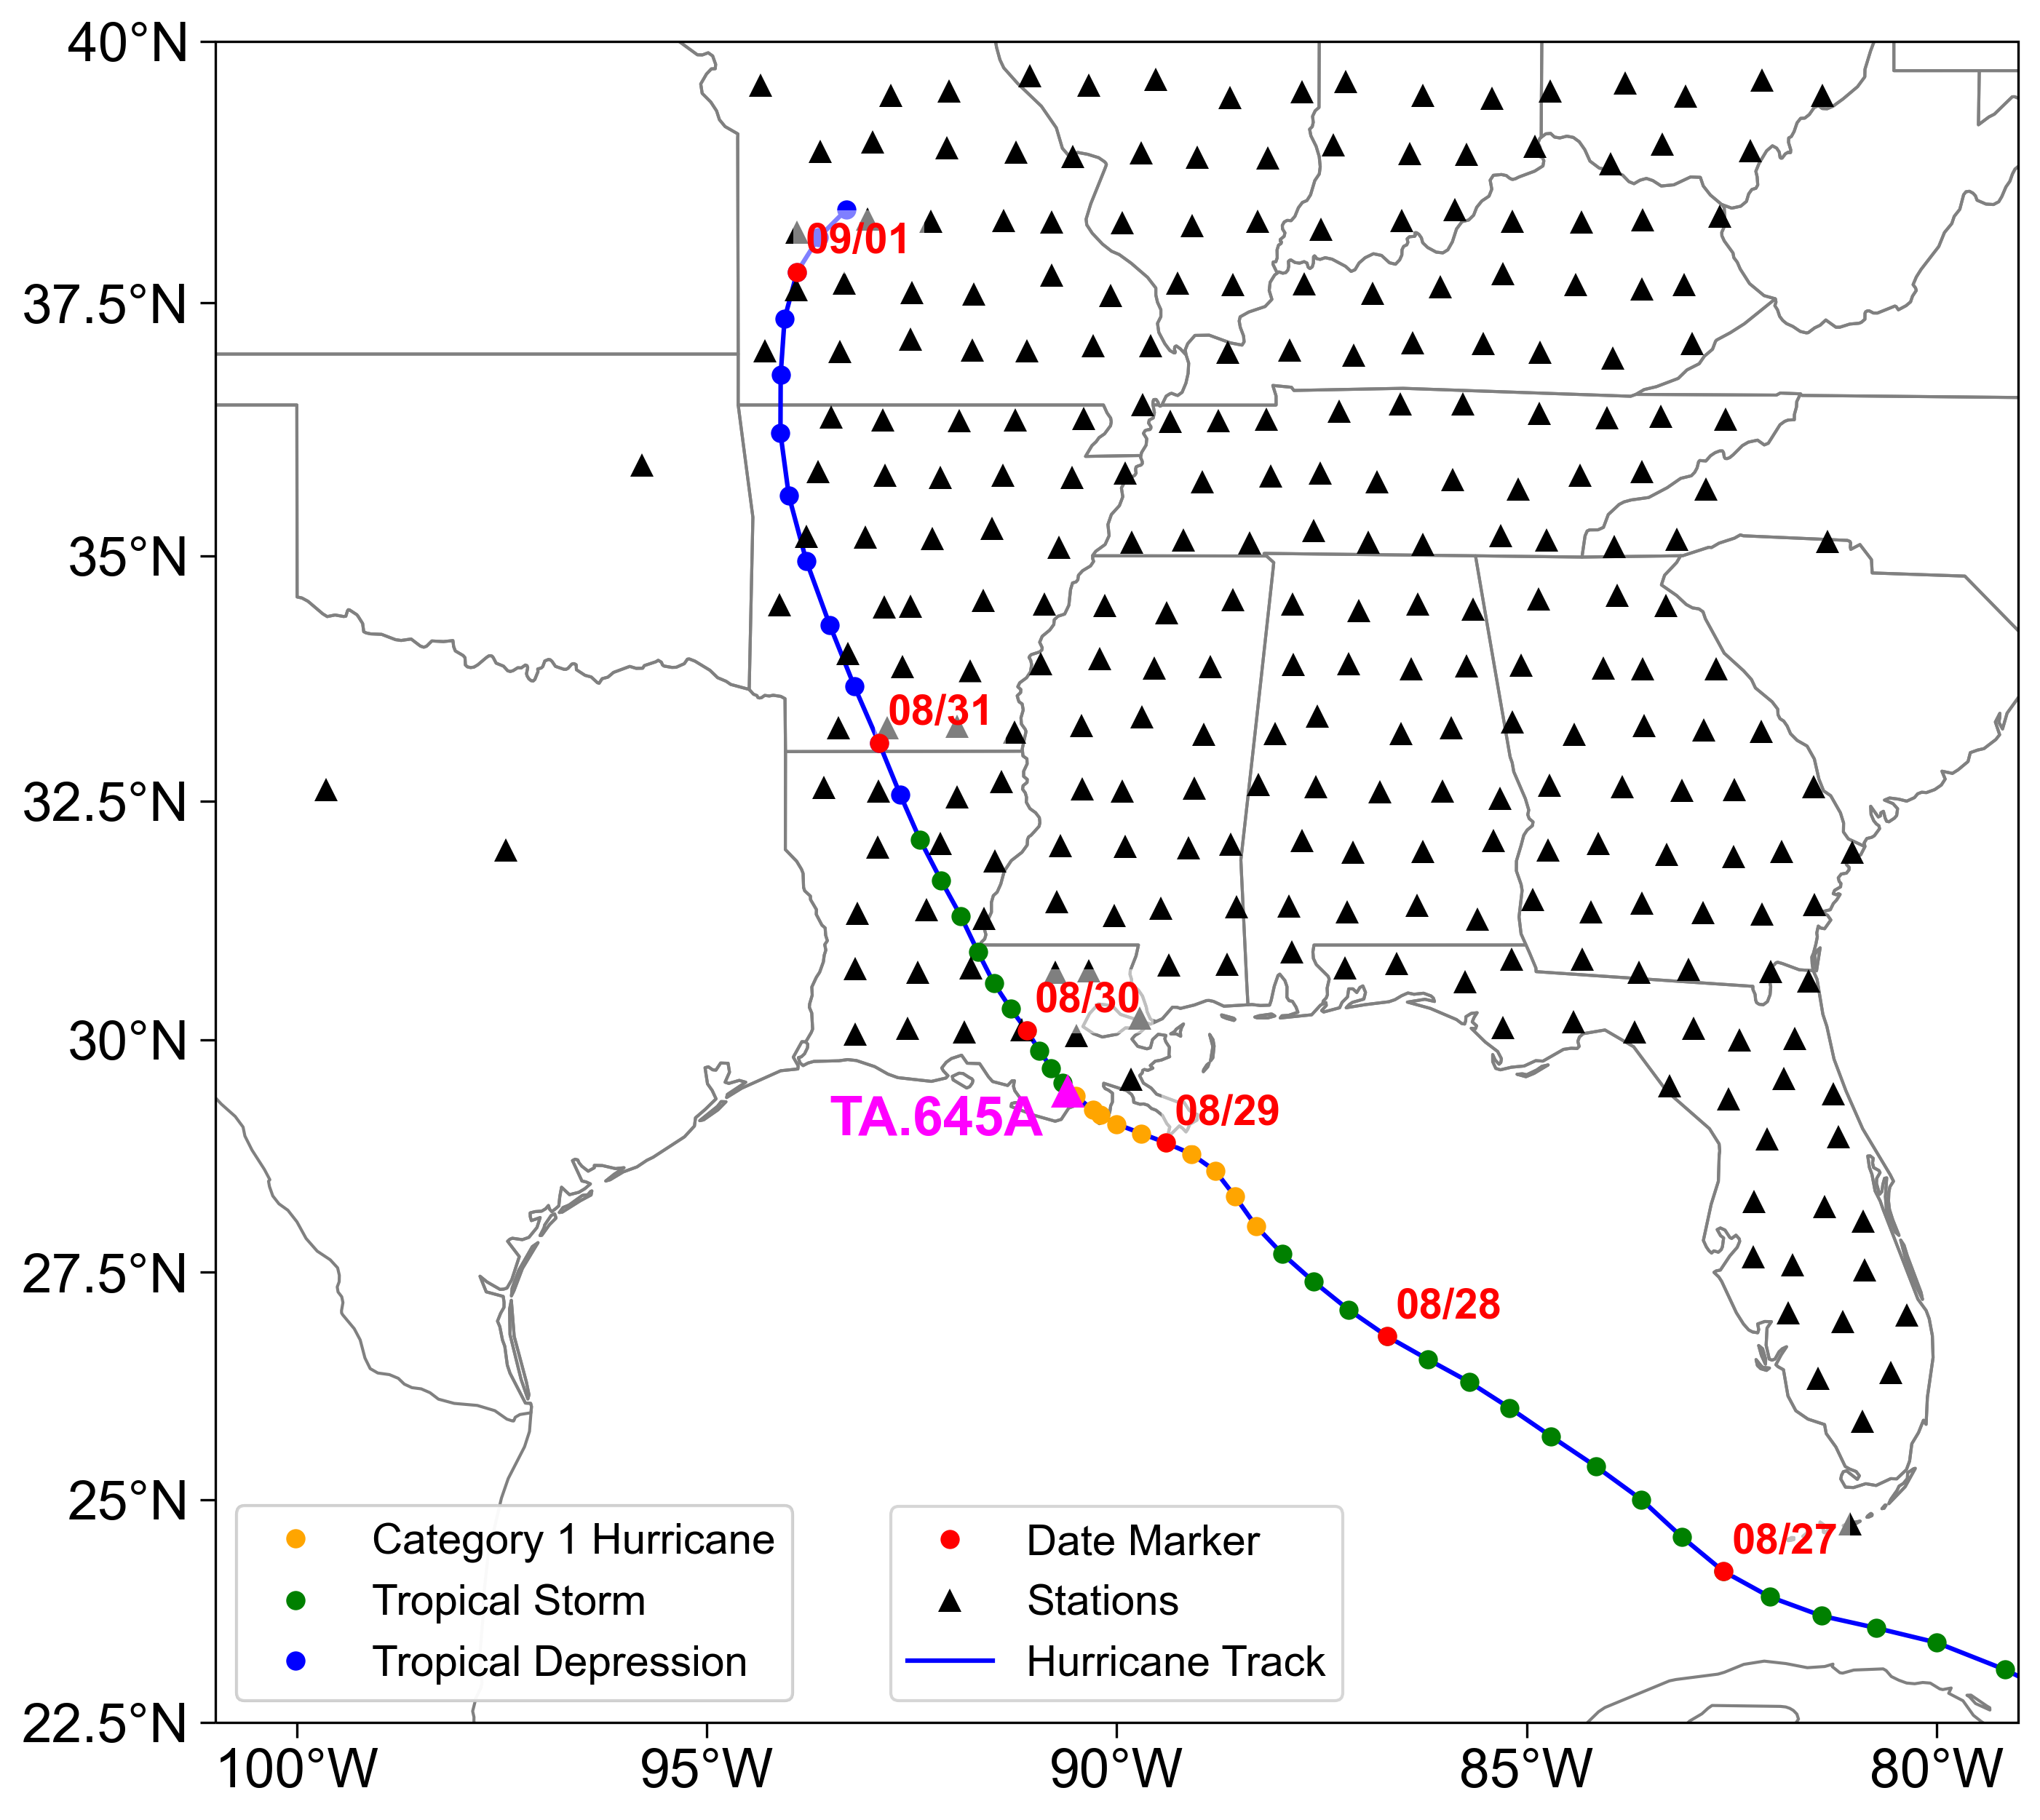

In [38]:
# Plot hurricane track & seismic stations (Figure 1)
fig, ax = make_plot_map(tc_info, sta_info, f_loc)

## Wavelet PSD for single station analysis

In [278]:
from my_func.xwt import myxwt, cwt
from my_func.seis_func import download_trace, check_npts
from my_func.plot_cwt import plot_wt_psd, plot_wt_coh, plot_wt_csd_phase
from my_func.preprocess import interp_track, get_station_dist

In [277]:
# Time interval for spectrograms
# Figure 2, 3, 8a: 2012 8/27    - 9/1      (./Data/cwt_spectra/psd_short.npz)
# Figure 4:        2012 8/24/12 - 9/3/12   (./Data/cwt_spectra/psd_long.npz)

# Network and station name
sta_char = ['TA', '645A']

# Time interval for analysis
# (You may read the pre-computed spectrogram for comparison)
ts = UTCDateTime(2012,8,27,0)  # UTCDateTime(2012,8,27,0), UTCDateTime(2012,8,24,12), UTCDateTime(2012,8,1,0)
te = UTCDateTime(2012,9,1,0)   # UTCDateTime(2012,9,1,0),  UTCDateTime(2012,9,3,12),  UTCDateTime(2012,8,11,0)

# Note: Downloaded data will be longer than the above range, so as to avoid cone of instability (coi)
extra_portion = 1e-3

# Download pressure and/or seismic displacement data
# Instrument response is removed
# For displacement: Positive means downward, corrected based on channel dip angle

# List of channels
channel_list = ['LDF', 'LHZ']  # Include ['LHN', 'LHE'] for H/V ratio

# Download data
stream = Stream()
for channel in channel_list:
    trace, sta_loc = download_trace(sta_char, [ts, te], channel, pre_filt='default', 
                                    extra_portion=extra_portion, client=Client('IRIS'))
    stream = stream + trace

# Check number of data points
# (Infrasound LDF channel sometimes have 1 data point less)
stream = check_npts(stream)

# Remove unused variable
del trace

In [151]:
# Wavelet analysis: Pressure and vertical disp.
# nptsfreqs is 400 for figures in the paper.

### Compute wavelet PSDs, CSD & Coherence ###
# dt = stream[0].stats.delta
# timestamp = stream[0].times('matplotlib')

# psd_p, psd_uz, csd_p_uz, coh, freqs, _ = myxwt(stream[0].data, stream[1].data, 1/dt, ns=3, nt=0.25, vpo=12, 
#                                                freqmin=0.005, freqmax=0.4, nptsfreq=100, smooth=False)
######

### Read pre-computed spectrogram ###
tmp_data = np.load('./Data/cwt_spectra/psd_short.npz')

t1, dt, step, freqs = tmp_data['ts'], tmp_data['dt'], tmp_data['decimate'], tmp_data['freqs']
psd_p, psd_uz, csd_p_uz, coh = tmp_data['psd_p'], tmp_data['psd_uz'], tmp_data['csd_p_uz'], tmp_data['coh']
timestamp = t1 + np.arange(psd_p.shape[1]) * dt/86400 * step

del tmp_data
######

In [ ]:
# Save spectrogram
# decimate = 60
# np.savez('./Data/cwt_spectra/psd_short.npz', ts=stream[0].times('matplotlib')[0], dt=stream[0].stats.delta, 
#          decimate=decimate, freqs=freqs, psd_p=psd_p[:, ::decimate], psd_uz=psd_uz[:, ::decimate], 
#          csd_p_uz=csd_p_uz[:, ::decimate], coh=coh[:, ::decimate])

In [146]:
# Interpolate TC track
tc_timestamp, tc_lon, tc_lat = interp_track([ts, te], f_loc, t0)

# Station distance to hurricane center [km]
tc_dist = get_station_dist(sta_loc, np.array([tc_lon, tc_lat]))

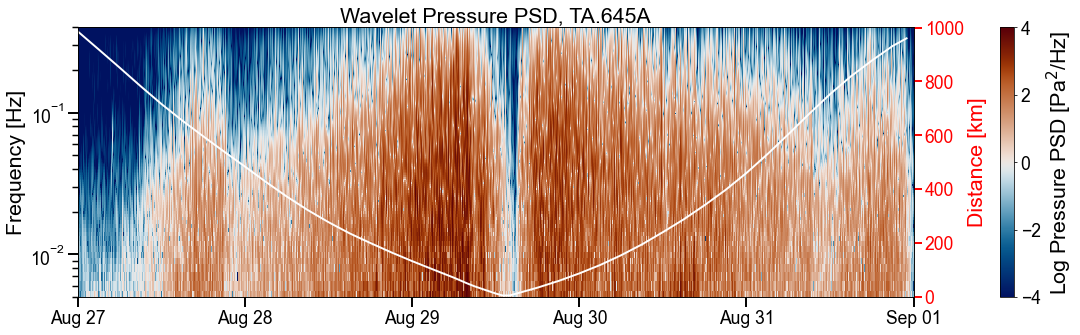

In [147]:
# Decimate ratio (reduce temporal sampling for plotting)
# If using pre-computed spectrogram, set to 1 (already down-sampled when storing the results)
# Otherwise, set to 60 (one point every minute) or larger
decimate = 1

# Plot pressure wavelet PSD (Figure 2a)
plot_prs = plot_wt_psd(timestamp, freqs, psd_p, channel='LDF',
                       decimate=decimate, freq_scale='log', value_range=[-4,4], title='.'.join(sta_char),
                       tc_time=tc_timestamp, tc_dist=tc_dist, dist_range=[0,1e3])

# Modification
plot_prs[1].set_xlim(ts-1, te+1)
plot_prs[2].set_ylim(-1, 1001)
plot_prs[1].xaxis.set_major_formatter(mdates.DateFormatter('%h %d'))

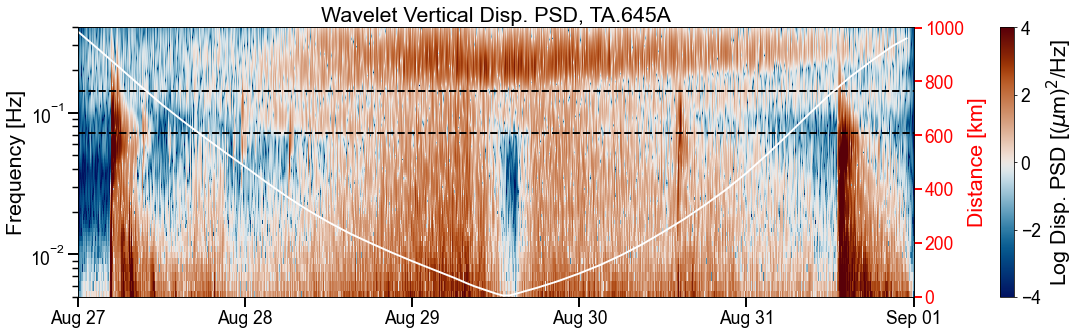

In [148]:
# Plot vertical disp. wavelet PSD (Figure 2b)
plot_uz = plot_wt_psd(timestamp, freqs, psd_uz, channel='LHZ',
                      decimate=decimate, freq_scale='log', value_range=[-4,4], title='.'.join(sta_char),
                      tc_time=tc_timestamp, tc_dist=tc_dist, dist_range=[0,1e3])

# Modification
plot_uz[1].set_xlim(ts-1, te+1)
plot_uz[2].set_ylim(-1, 1001)
plot_uz[1].xaxis.set_major_formatter(mdates.DateFormatter('%h %d'))

# Plot reference frequencies
for val in [1/7, 1/14]:
    plot_uz[1].axhline(y=val, color='k', linestyle='--', linewidth=2)

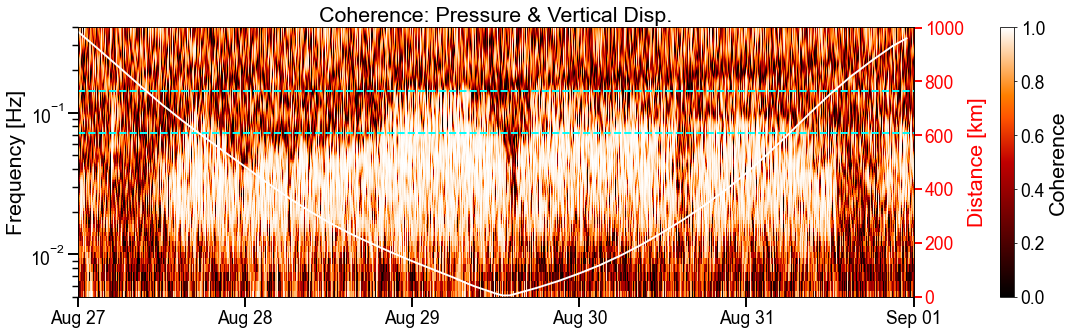

In [149]:
# Plot wavelet coherence (Figure 3a)
plot_coh_pz = plot_wt_coh(timestamp, freqs, coh, decimate=decimate, 
                          title='.'.join(sta_char), cmap='gist_heat', freq_scale='log',
                          tc_time=tc_timestamp, tc_dist=tc_dist, dist_range=[0,1e3])

# Modification
plot_coh_pz[1].set_xlim(ts-1, te+1)
plot_coh_pz[2].set_ylim(-1, 1001)
plot_coh_pz[1].xaxis.set_major_formatter(mdates.DateFormatter('%h %d'))
plot_coh_pz[1].set_title('Coherence: Pressure & Vertical Disp.')

# Plot reference frequencies
for val in [1/7, 1/14]:
    plot_coh_pz[1].axhline(y=val, color='cyan', linestyle='--', linewidth=2)

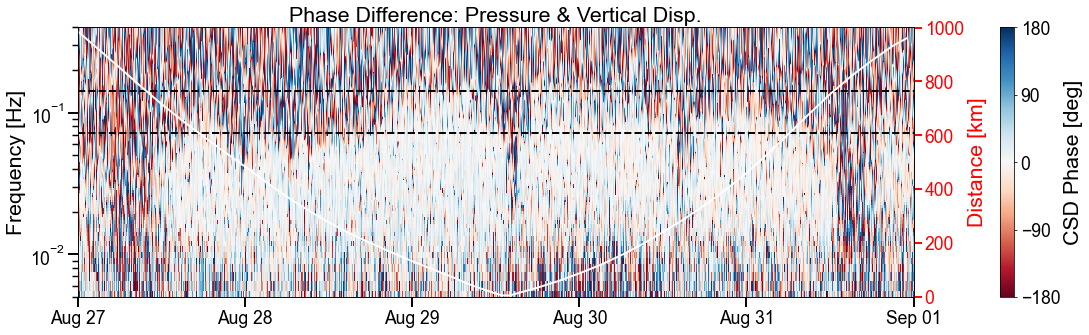

In [150]:
# Plot wavelet CSD phase (Figure 3b)
plot_csd_phase = plot_wt_csd_phase(timestamp, freqs, csd_p_uz, decimate=decimate, 
                                   title='.'.join(sta_char), cmap='RdBu', freq_scale='log',
                                   tc_time=tc_timestamp, tc_dist=tc_dist, dist_range=[0,1e3])

# Modification
plot_csd_phase[1].set_xlim((ts-1).matplotlib_date, (te+1).matplotlib_date)
plot_csd_phase[2].set_ylim(-1, 1001)
plot_csd_phase[1].xaxis.set_major_formatter(mdates.DateFormatter('%h %d'))
plot_csd_phase[1].set_title('Phase Difference: Pressure & Vertical Disp.')

# Plot reference frequencies
for val in [1/7, 1/14]:
    plot_csd_phase[1].axhline(y=val, color='k', linestyle='--', linewidth=2)

## Wavelet PSD: Diurnal cycle

In [155]:
from my_func.preprocess import read_ASOS_data

In [157]:
# Diurnal cycles (Figure 4)

### Read pre-computed spectrogram ###
tmp_data = np.load('./Data/cwt_spectra/psd_long.npz')

t1, dt, step, freqs = tmp_data['ts'], tmp_data['dt'], tmp_data['decimate'], tmp_data['freqs']
psd_p, psd_uz, csd_p_uz, coh = tmp_data['psd_p'], tmp_data['psd_uz'], tmp_data['csd_p_uz'], tmp_data['coh']
timestamp = t1 + np.arange(psd_p.shape[1]) * dt/86400 * step

del tmp_data

### Read ASOS temperature & wind data ###
asos_T, asos_wind = read_ASOS_data()

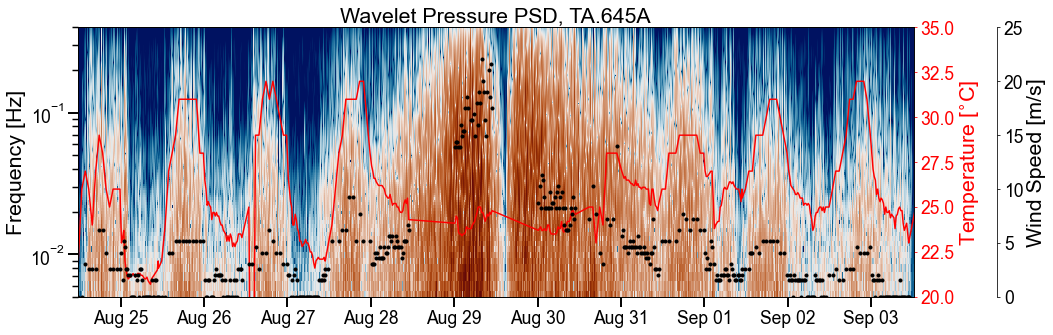

In [164]:
# Plot pressure wavelet PSD (Figure 4a)
plot_prs = plot_wt_psd(timestamp, freqs, psd_p, channel='LDF',
                       decimate=1, freq_scale='log', value_range=[-4,4], title='.'.join(sta_char))

# Modification
plot_prs[1].xaxis.set_major_formatter(mdates.DateFormatter('%h %d'))

# Add ASOS data (temperature & wind)
ax_T = plot_prs[1].twinx()
# mask = (asos_T > 20)  # Remove some outliers
ax_T.plot(asos_T['time'], asos_T['T'], 'r-')
ax_T.tick_params(axis='y', colors='r')
ax_T.set_ylabel('Temperature [$^{\circ}$C]', color='r')
ax_T.set_ylim(20, 35)

ax_wind = plot_prs[1].twinx()
# mask = (asos_wind > 0)  # Remove some outliers
ax_wind.scatter(asos_wind['time'], asos_wind['wind'], color='k', s=10)
ax_wind.tick_params(axis='y', colors='k')
ax_wind.set_ylabel('Wind Speed [m/s]', color='k')
ax_wind.set_ylim(0, 25)
ax_wind.spines["right"].set_position(("axes", 1.1))

plot_prs[0].delaxes(plot_prs[0].axes[1])

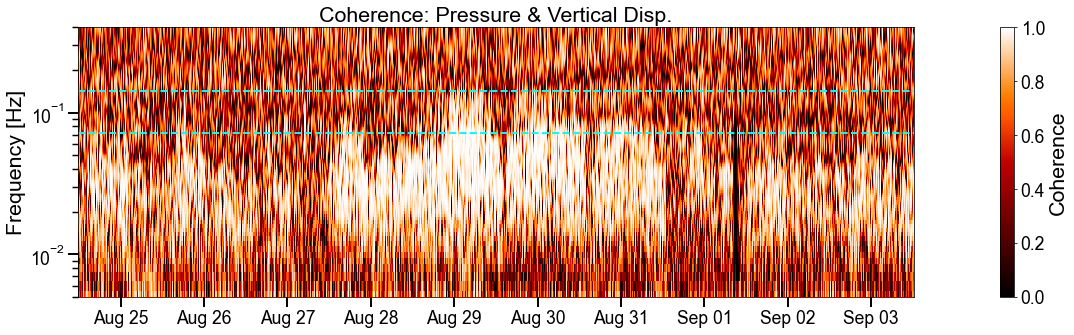

In [163]:
# Plot wavelet coherence (Figure 4b)
plot_coh_pz = plot_wt_coh(timestamp, freqs, coh, decimate=1, 
                          title='.'.join(sta_char), cmap='gist_heat', freq_scale='log')

# Modification
plot_coh_pz[1].xaxis.set_major_formatter(mdates.DateFormatter('%h %d'))
plot_coh_pz[1].set_title('Coherence: Pressure & Vertical Disp.')

# Plot reference frequencies
for val in [1/7, 1/14]:
    plot_coh_pz[1].axhline(y=val, color='cyan', linestyle='--', linewidth=2)

## Wavelet spectral snapshot

In [285]:
from my_func.preprocess import read_psd_db, extract_psd_snapshot
from my_func.plot_cwt import plot_psd_snapshot

In [253]:
### Snapshot time (round to every half hour) ###
snapshot_time = UTCDateTime('20120829-1030')

### Component ###
# Pressure ('prs'), Vertical Disp. ('uz')
comp = 'prs'

# Extract PSD data
snapshot_data = extract_psd_snapshot(snapshot_time, comp=comp, sta_info=sta_info, 
                                     db_dir='./Data/psd_data/')

### db_dir includes wavelet PSD for 1-hr data at all stations, averaged over 20 - 100 s ###

Time interval: 08-29 10:00 to 08-29 11:00


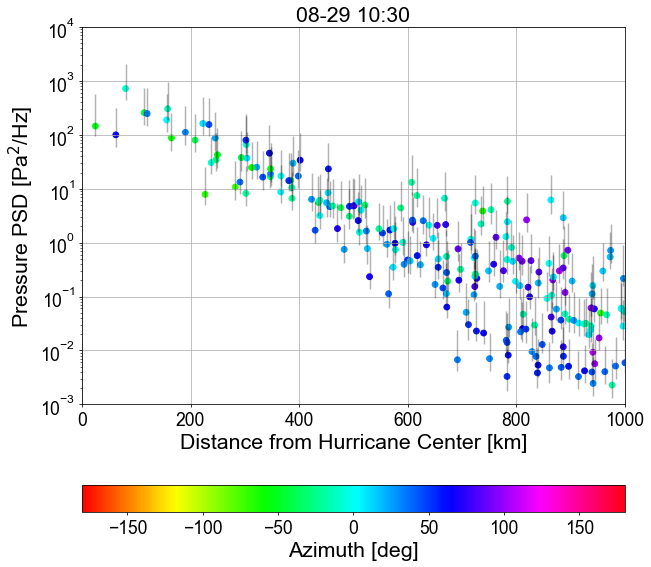

In [254]:
# Plot PSD snapshot (Figure 5)
fig, ax = plot_psd_snapshot(snapshot_data, comp=comp, snapshot_time=snapshot_time, 
                            az_color=True, show_cb=True)

## Surface wind & Input pressure PSD

In [249]:
from my_func.preprocess import read_Hwind_data
from my_func.plot_maps import plot_Hwind_snapshot, plot_Hwind_profile

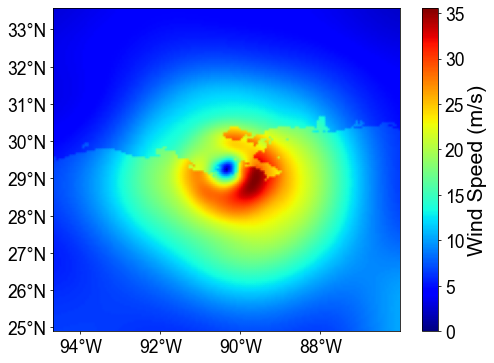

In [262]:
### HWind surface wind reanalysis ###
df_wind, center_loc = read_Hwind_data('./Data/Hwind/AL092012_0829_1030')
Hwind_time = UTCDateTime('20120829-1030')

# Plot surface wind snapshot
fig, ax = plot_Hwind_snapshot(df_wind)

In [248]:
### Create parametric wind models ###

def wind_model(Rm, Vm, b, I, df):
    
    # Air density [kg/m^3]
    rho = 1.2
    
    # Parameter solved by forcing the maximum value to Vm
    # Eqn. (1)
    a = Rm**(2-b) / (b-1)
    C = b / (b-1) / 2

    # Return function handles
    # Eqns (1) & (2)
    wind_m = lambda r: r*(2*Rm*Vm) / (Rm**2 + a*(r**b)) * C
    prs_m = lambda r: wind_m(r)**4 * (0.7**2 * rho**2 * I**4) / (2*df)
    
    return wind_m, prs_m

# Frequency range
df = 0.04

# Upper bound
[R1, V1, b1, I1] = [75, 36, 2.0, 0.13]
# Median
[Rm, Vm, bm, Im] = [70, 28, 2.2, 0.13]
# Lower bound
[R2, V2, b2, I2] = [68, 20, 2.5, 0.13]

[wm1, pm1] = wind_model(R1, V1, b1, I1, df)
[wm2, pm2] = wind_model(R2, V2, b2, I2, df)
[wm, pm]   = wind_model(Rm, Vm, bm, Im, df)

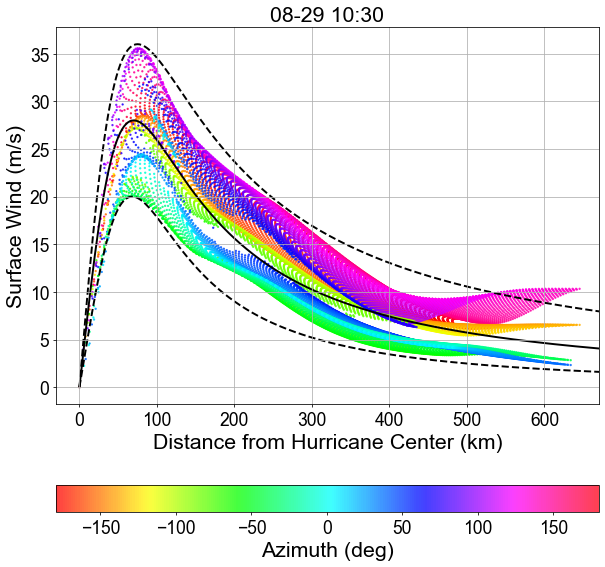

In [263]:
# Plot surface wind profile (Figure 6a)
fig, ax = plot_Hwind_profile(df_wind['dist(km)'], df_wind['ws(m/s)'], az=df_wind['az(deg)'])
ax.set_title(Hwind_time.strftime('%m-%d %H:%M'))
ax.set_xlim(-30, 670)

# Plot wind models
r = np.linspace(0, 1000, 401)
ax.plot(r, wm1(r), 'k--', r, wm2(r), 'k--', r, wm(r), 'k-', linewidth=2, zorder=1)
fig.show()

Time interval: 08-29 10:00 to 08-29 11:00


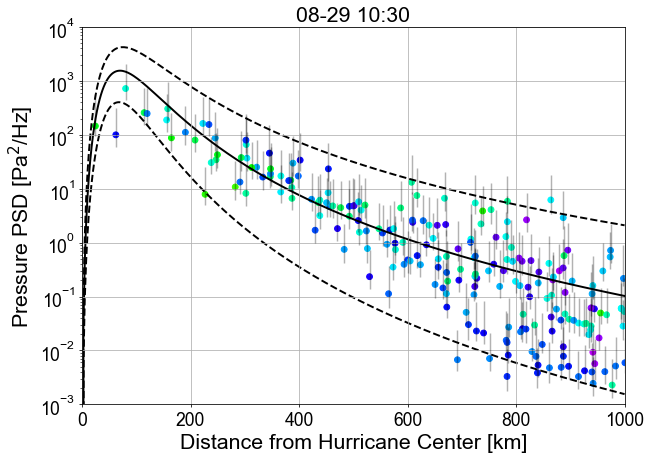

In [264]:
# Plot pressure PSD snapshot (Figure 6b)
prs_data = extract_psd_snapshot(Hwind_time, comp='prs', sta_info=sta_info, db_dir='./Data/psd_data/')
fig, ax = plot_psd_snapshot(prs_data, comp='prs', snapshot_time=Hwind_time, az_color=True, show_cb=False)

# Plot wind models
ax.plot(r, pm1(r), 'k--', r, pm2(r), 'k--', r, pm(r), 'k-', linewidth=2, zorder=1)
fig.show()

## Seismic modeling results

In [269]:
from my_func.plot_maps import plot_model_result

Time interval: 08-29 10:00 to 08-29 11:00


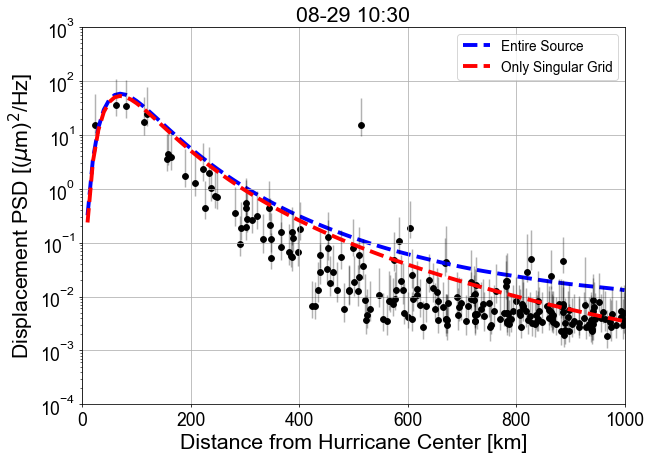

In [273]:
### Read seismic modeling results ###
result_dir = './Data/model_results/'
fit_singular = loadmat(result_dir + 'syn_291030_singular.mat')
fit_constL = loadmat(result_dir + 'syn_291030_constL.mat')

# Plot seismic PSD snapshot
uz_data = extract_psd_snapshot(Hwind_time, comp='uz', sta_info=sta_info, db_dir='./Data/psd_data/')
fig, ax = plot_psd_snapshot(uz_data, comp='uz', snapshot_time=Hwind_time, az_color=False, show_cb=False)

# Plot modeling results (Figure 7a)
ax = plot_model_result(fit_constL, ax=ax, color='b', linestyle='--', linewidth=4, 
                       label='Entire Source', zorder=1)
ax = plot_model_result(fit_singular, ax=ax, color='r', linestyle='--', linewidth=4, 
                       label='Only Singular Grid', zorder=2)
ax.legend()
fig.show()

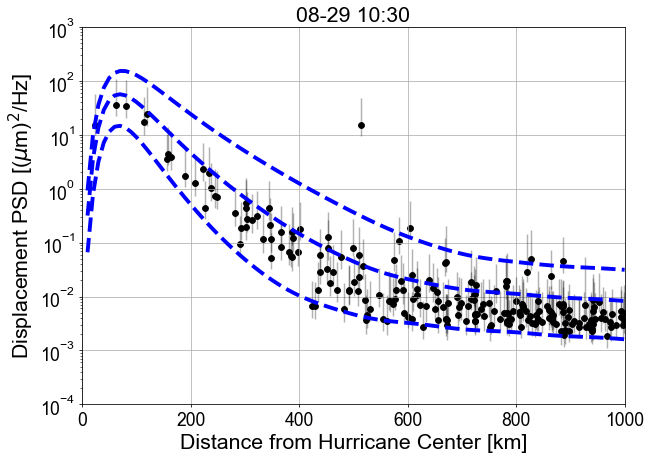

In [276]:
### Read seismic modeling results ###
fit_median = loadmat(result_dir + 'syn_291030_decayL.mat')
fit_upper = loadmat(result_dir + 'syn_291030_decayL_upper.mat')
fit_lower = loadmat(result_dir + 'syn_291030_decayL_lower.mat')

# Plot seismic PSD snapshot
fig, ax = plot_psd_snapshot(uz_data, comp='uz', snapshot_time=Hwind_time, az_color=False, show_cb=False)

# Plot modeling results (Figure 7b)
ax = plot_model_result(fit_median, ax=ax, color='b', linestyle='--', linewidth=4)
ax = plot_model_result(fit_upper, ax=ax, color='b', linestyle='--', linewidth=4)
ax = plot_model_result(fit_lower, ax=ax, color='b', linestyle='--', linewidth=4)
fig.show()

## H/V ratio: Observation

In [283]:
# Wavelet analysis: Seismic vertical & horizontal disp.
# nptsfreqs is 400 for figures in the paper.

### Compute wavelet PSDs ###
# dt = stream[1].stats.delta
# timestamp = stream[1].times('matplotlib')

# psd_uz, freqs, _ = cwt(stream[1].data, 1/dt, ns=3, nt=0.25, vpo=12, 
#                        freqmin=0.005, freqmax=0.4, nptsfreq=100, smooth=False)
# psd_un,     _, _ = cwt(stream[2].data, 1/dt, ns=3, nt=0.25, vpo=12, 
#                        freqmin=0.005, freqmax=0.4, nptsfreq=100, smooth=False)
# psd_ue,     _, _ = cwt(stream[3].data, 1/dt, ns=3, nt=0.25, vpo=12, 
#                        freqmin=0.005, freqmax=0.4, nptsfreq=100, smooth=False)
######

### Read pre-computed spectrogram ###
tmp_data = np.load('./Data/cwt_spectra/HV_short.npz')

t1, dt, step, freqs = tmp_data['ts'], tmp_data['dt'], tmp_data['decimate'], tmp_data['freqs']
HV_ratio = tmp_data['HV_ratio']
timestamp = t1 + np.arange(psd_p.shape[1]) * dt/86400 * step

del tmp_data
######

In [281]:
# Save spectrogram
# decimate = 60
# HV_ratio = np.sqrt(psd_un+psd_ue) / np.sqrt(psd_uz)
# np.savez('./Data/cwt_spectra/HV_short.npz', ts=stream[1].times('matplotlib')[0], dt=stream[1].stats.delta, 
#          decimate=decimate, freqs=freqs, psd_uz=psd_uz[:, ::decimate], 
#          psd_un=psd_un[:, ::decimate], psd_ue=psd_ue[:, ::decimate], HV_ratio=HV_ratio[:, ::decimate])

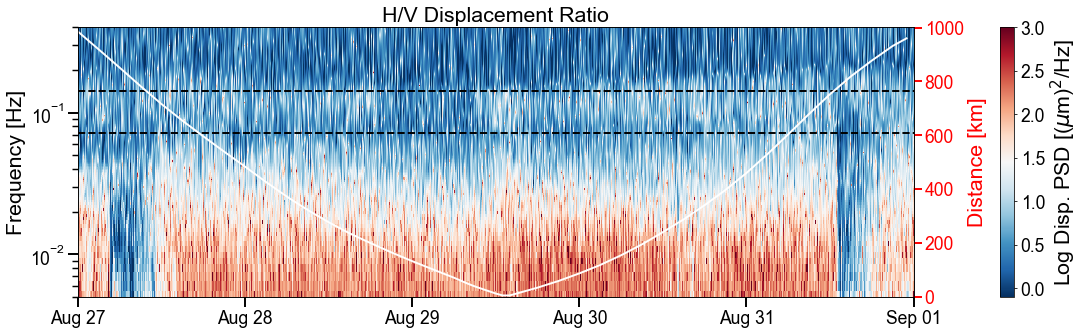

In [284]:
# Decimate ratio (reduce temporal sampling for plotting)
# If using pre-computed spectrogram, set to 1 (already down-sampled when storing the results)
# Otherwise, set to 60 (one point every minute) or larger
decimate = 1

# Plot vertical disp. wavelet PSD (Figure 8a)
plot_HV = plot_wt_psd(timestamp, freqs, HV_ratio, cb_label='Log H/V Ratio', decimate=decimate, 
                      freq_scale='log', value_range=[-0.1,3], cmap='RdBu_r', title='.'.join(sta_char),
                      tc_time=tc_timestamp, tc_dist=tc_dist, dist_range=[0,1e3])

# Modification
plot_HV[1].set_xlim(ts-1, te+1)
plot_HV[2].set_ylim(-1, 1001)
plot_HV[1].xaxis.set_major_formatter(mdates.DateFormatter('%h %d'))
plot_HV[1].set_title('H/V Displacement Ratio')

# Plot reference frequencies
for val in [1/7, 1/14]:
    plot_HV[1].axhline(y=val, color='k', linestyle='--', linewidth=2)

Station count: 91


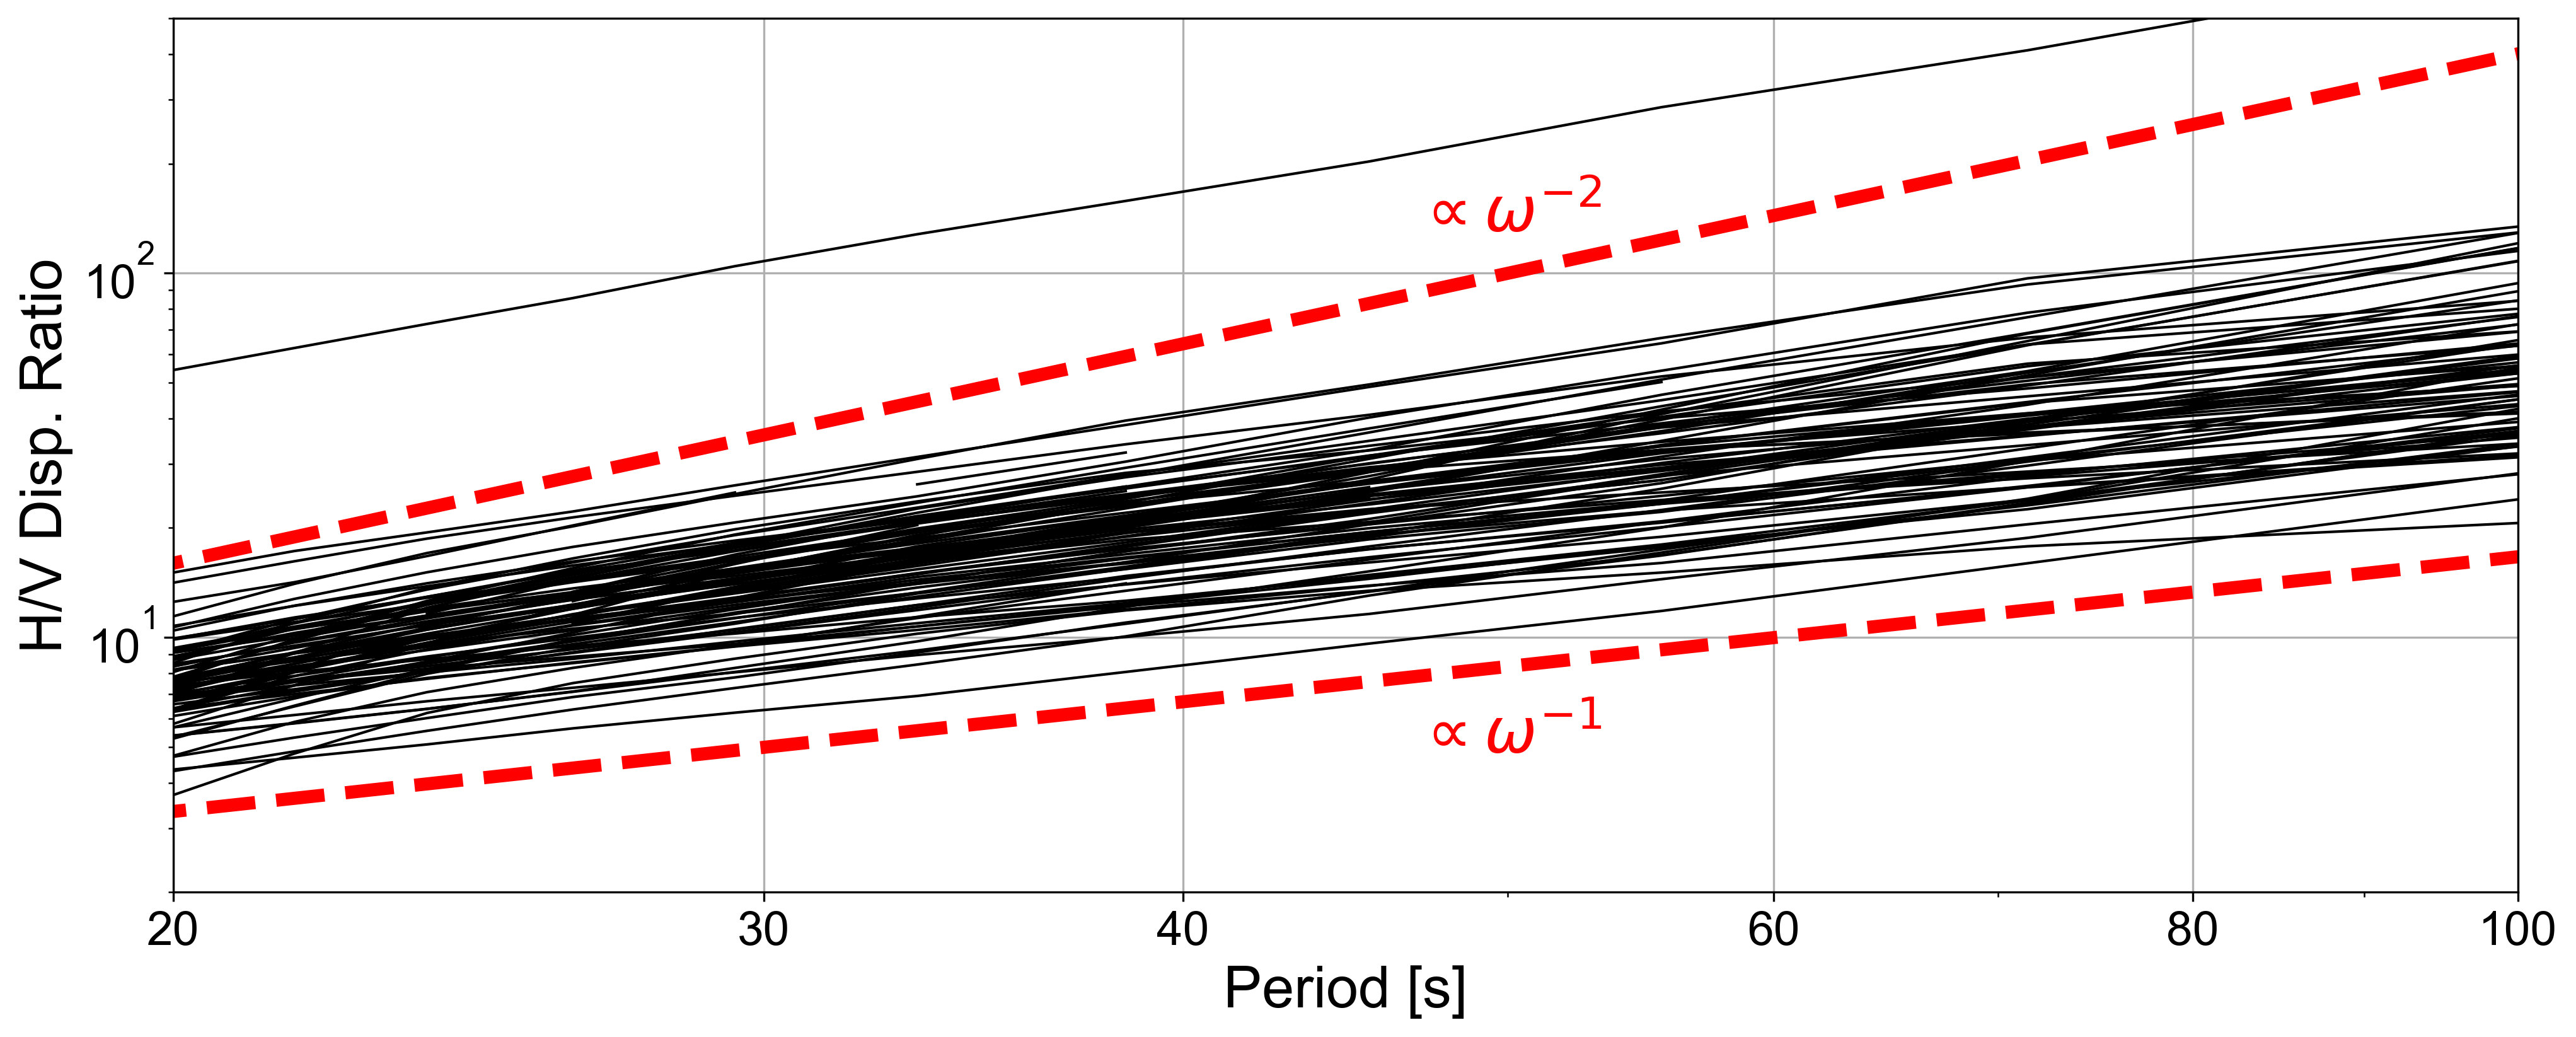

In [302]:
### Read H/V ratio & coherence data ###
HV_med, HV_quar1, HV_quar3 = read_psd_db(db_dir='./Data/coh_data/', comp='HV')
coh_med, coh_quar1, coh_quar3 = read_psd_db(db_dir='./Data/coh_data/', comp='coh')
HV_freqs = np.array(HV_med.columns[1:], dtype=float)

# Plot stations with median coherence > 0.6
fig, ax = plt.subplots(figsize=(16,6), dpi=300)

sta_count = 0
for i in range(HV_med.shape[0]):
    ind_f = (coh_med.iloc[i, 1:].to_numpy() > 0.6)  # Select frequency points with high coherence
    if np.any(ind_f):
        ax.plot(1/HV_freqs[ind_f], (HV_med.iloc[i, 1:].T[ind_f]), 'k', linewidth=1)
        sta_count += 1
print('Station count: %d' %sta_count)

# Plot reference scaling relation
ref_T = np.linspace(10,200,100)
ref_HV1 = ref_T / 6
ref_HV2 = ref_T**2 / 25
ax.plot(ref_T, ref_HV1, 'r--', linewidth=5)
ax.plot(ref_T, ref_HV2, 'r--', linewidth=5)

# Modification
ax.set_xlabel('Period [s]')
ax.set_ylabel('H/V Disp. Ratio')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([20, 30, 40, 60, 80, 100], [20, 30, 40, 60, 80, 100])
ax.set_xlim([20, 100])
ax.set_ylim([2, 500])
ax.grid()

ax.text(50, 6.5, '$\propto \omega^{-1}$', horizontalalignment='center', verticalalignment='top', 
        color='r', fontsize=24)
ax.text(50, 120, '$\propto \omega^{-2}$', horizontalalignment='center', verticalalignment='bottom', 
        color='r', fontsize=24)
fig.show()